In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch
import torch.nn as nn
import torch.nn.functional as F

import utils, extreme, archimedean, importlib
import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

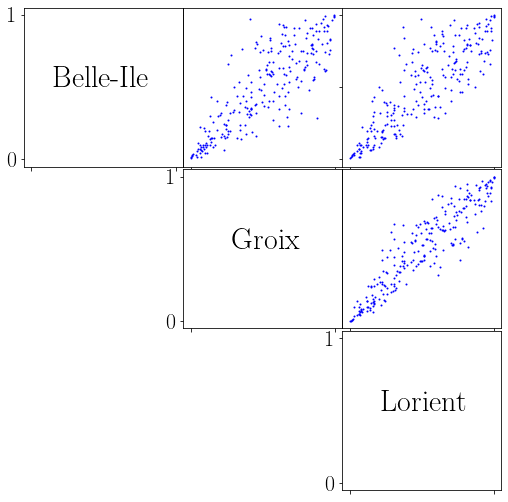

<Figure size 432x288 with 0 Axes>

In [2]:
nsamples = 240 # monthly maxima
ndims = 3

path = './data/synthetic/CNSD_C_1_14.p'
U0 = utils.load_data_0(path).float();
 
labels = ["Belle-Ile", "Groix", "Lorient"]
utils.plot_U(U0, labels=labels)

stdf = extreme.stdfNSD(alpha = torch.tensor([1.,2.,3.]), rho = torch.tensor([-0.69]))

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(ndims, 128)
        self.fc21 = nn.Linear(128, 16)
        self.fc22 = nn.Linear(128, 16)
        
        self.fc3 = nn.Linear(16, 128)
        self.fc4 = nn.Linear(128, ndims)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, ndims))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, ndims), reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return 50*MSE + KLD

In [4]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_batch = 200
n_iter = 5000

loss_array = np.zeros(n_iter)
time_array = np.zeros(int(n_iter/100))
iter_array = np.zeros(int(n_iter/100))
time_taken = 0
    
for iter_stdf in range(n_iter):
    
    data = U0[np.random.randint(0,nsamples,n_batch),:].detach()
    
    time_start = time.time()
    
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar)
    loss.backward()
    optimizer.step()

    time_end = time.time()
    time_taken += (time_end-time_start)

    loss_array[iter_stdf] = loss.item()
    
    if iter_stdf % 100 == 0:

        time_array[int(iter_stdf/100)] = time_taken
        iter_array[int(iter_stdf/100)] = iter_stdf
        print(iter_stdf, time_taken, loss.item())

0 0.18181800842285156 4.369853496551514
100 0.35851359367370605 0.9588130712509155
200 0.5238597393035889 0.7455511093139648
300 0.6774768829345703 0.6077318787574768
400 0.8335676193237305 0.5915613770484924
500 1.0130467414855957 0.47351786494255066
600 1.192756175994873 0.41310131549835205
700 1.3680965900421143 0.4097493886947632
800 1.540205478668213 0.3917255997657776
900 1.714111328125 0.364124596118927
1000 1.8883237838745117 0.3545013666152954
1100 2.045792579650879 0.3380315899848938
1200 2.205192804336548 0.33824026584625244
1300 2.3612115383148193 0.362447589635849
1400 2.530653953552246 0.3618679642677307
1500 2.7015528678894043 0.33872801065444946
1600 2.881863594055176 0.33120232820510864
1700 3.053166389465332 0.32929855585098267
1800 3.21164608001709 0.33788830041885376
1900 3.366985321044922 0.32228735089302063
2000 3.5248653888702393 0.3478282392024994
2100 3.685901403427124 0.32857879996299744
2200 3.843916177749634 0.3546667993068695
2300 4.000003337860107 0.322458

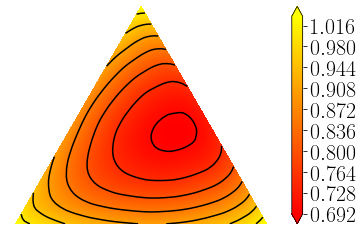

0.14414161443710327


In [5]:
# block maximas and compute IRAE

fake = model.decode(torch.randn((200000,16)))

Uev = fake.view(100,2000,ndims).max(dim=0)[0].detach().numpy()
for i in range(ndims):
    Uev[:, i] = scipy.stats.rankdata(Uev[:, i], 'ordinal')/2000
utils.plot_stdf3(extreme.stdfCFG(torch.tensor(Uev)))

U_test = utils.rand_simplex(10000,ndims)

stdfmax = extreme.stdfCFG(torch.tensor(Uev))(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)